In [ ]:
# Necessary imports
import findspark
findspark.init() 

import sys
from pathlib import Path

sys.path.append(str(Path("../..").resolve()))

from src.data_ingestion import *
from src.data_preprocessing import *



In [9]:
spark = init_spark()
df = load_data(spark, "../../data/US_Accidents_March23.csv")


In [ ]:
from pyspark.sql.functions import hour, dayofweek, month, year, when

df = df.withColumn("hour_of_day", hour(df["Start_Time"]))
df = df.withColumn("day_of_week", dayofweek(df["Start_Time"]))
df = df.withColumn("month", month(df["Start_Time"]))
df = df.withColumn("year", year(df["Start_Time"]))

df = df.withColumn("weather_condition_cat", when(df["Weather_Condition"] == "Clear", 0)
                                            .when(df["Weather_Condition"] == "Rain", 1)
                                            .when(df["Weather_Condition"] == "Snow", 2)
                                            .otherwise(3))

df = df.withColumn("is_night", when((df["hour_of_day"] >= 18) | (df["hour_of_day"] < 6), 1).otherwise(0))

df = df.withColumn("severe_accident", when(df["Severity"] >= 3, 1).otherwise(0))

df.show(5)


+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-----------+-----+----+---------------------+--------+---------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visib

In [11]:
# Fill missing values in columns like temperature, wind speed with the mean or median
from pyspark.ml.feature import Imputer

imputer = Imputer(inputCols=["Temperature(F)", "Wind_Speed(mph)", "Humidity(%)"], outputCols=["Temperature_imputed", "Wind_Speed_imputed", "Humidity_imputed"])
df = imputer.fit(df).transform(df)

# Drop rows with missing target variables (if any)
df = df.dropna(subset=["Severity"])


In [12]:
# Split the data into training and testing sets (80% train, 20% test)
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)


In [ ]:
from pyspark.sql.functions import col, expr

def filter_outliers(df, feature_col):
    percentile_25 = df.approxQuantile(feature_col, [0.25], 0.0)[0]
    percentile_75 = df.approxQuantile(feature_col, [0.75], 0.0)[0]
    iqr = percentile_75 - percentile_25

    lower_bound = percentile_25 - 1.5 * iqr
    upper_bound = percentile_75 + 1.5 * iqr

    df_filtered = df.filter((col(feature_col) >= lower_bound) & (col(feature_col) <= upper_bound))
    
    return df_filtered

train_data = filter_outliers(train_data, 'Distance(mi)')
test_data = filter_outliers(test_data, 'Distance(mi)')


In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

regression_features = ["hour_of_day", "day_of_week", "month", "Temperature_imputed", "Wind_Speed_imputed", "Humidity_imputed", "is_night", "weather_condition_cat"]
assembler = VectorAssembler(inputCols=regression_features, outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

lr = LinearRegression(labelCol="Distance(mi)", featuresCol="features")
lr_model = lr.fit(train_data)

lr_predictions = lr_model.transform(test_data)

from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="Distance(mi)", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(lr_predictions)
print(f"Root Mean Squared Error (RMSE) for Linear Regression: {rmse:.2f}")


Root Mean Squared Error (RMSE) for Linear Regression: 0.27


R2 for Linear Regression: 0.02
Mean Squared Error (MSE) for Linear Regression: 0.07


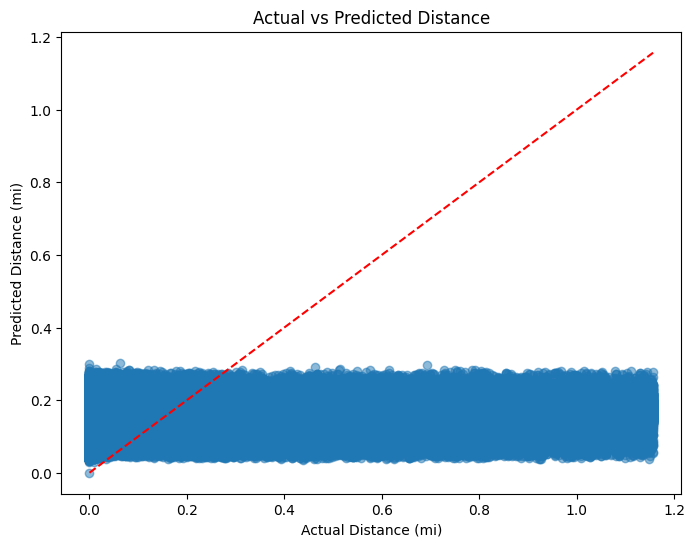

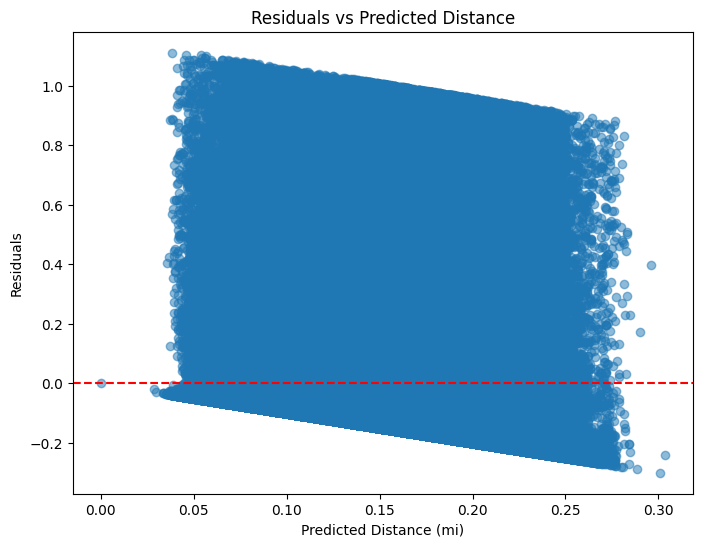

In [ ]:
r2 = evaluator.setMetricName("r2").evaluate(lr_predictions)
mse = evaluator.setMetricName("mse").evaluate(lr_predictions)

print(f"R2 for Linear Regression: {r2:.2f}")
print(f"Mean Squared Error (MSE) for Linear Regression: {mse:.2f}")

predictions_df = lr_predictions.select("Distance(mi)", "prediction").toPandas()

plt.figure(figsize=(8, 6))
plt.scatter(predictions_df["Distance(mi)"], predictions_df["prediction"], alpha=0.5)
plt.plot([min(predictions_df["Distance(mi)"]), max(predictions_df["Distance(mi)"])], 
         [min(predictions_df["Distance(mi)"]), max(predictions_df["Distance(mi)"])], color='red', linestyle='--')
plt.xlabel("Actual Distance (mi)")
plt.ylabel("Predicted Distance (mi)")
plt.title("Actual vs Predicted Distance")
plt.show()

predictions_df["residuals"] = predictions_df["Distance(mi)"] - predictions_df["prediction"]

plt.figure(figsize=(8, 6))
plt.scatter(predictions_df["prediction"], predictions_df["residuals"], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Distance (mi)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Distance")
plt.show()